# DINO Logit Lens: Analyzing Representations in ViT Models

In this notebook, we transfer the concept of the logit lens from language models (like GPT) to computer vision models — specifically to the self-supervised DINO model with Vision Transformers (ViT).

Objectives:
- Inspect how the [CLS] token representation evolves across layers.
- Compare intermediate representations with the final one.
- Measure similarity (e.g., cosine similarity) between intermediate and final predictions.
- Generate plots for ViT-S/16 and ViT-B/8 models (trained with DINO).

Method: extract the representation at a chosen layer, pass it through the remaining layers, and compare the output to the full forward pass result.

Model: [DINO repository](https://github.com/facebookresearch/dino)

In [ ]:
# !pip install torch torchvision timm matplotlib seaborn

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.datasets as datasets
import torchvision.models as models

from PIL import Image
import timm

import requests
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

c:\Users\olenk\PWProjects\WB_2_Project\VisualLogitLens\dino_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
T = transforms.Compose([
    transforms.Resize(256, interpolation=3),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225)),
])

urls = [
    'https://github.com/google/dreambooth/blob/main/dataset/rc_car/04.jpg?raw=true',
    'https://github.com/google/dreambooth/blob/main/dataset/rc_car/03.jpg?raw=true',
    'https://github.com/google/dreambooth/blob/main/dataset/rc_car/02.jpg?raw=true',
    'https://github.com/google/dreambooth/blob/main/dataset/rc_car/01.jpg?raw=true'
]
images = [T(Image.open(requests.get(url, stream=True).raw)) for url in urls]
inputs = torch.stack(images)  # (2, 3, 224, 224)

model = timm.create_model("vit_small_patch16_224_dino", pretrained=True)
model.eval()

blocks = model.blocks
norm = model.norm
embed_patch = model.patch_embed
cls_token = model.cls_token
pos_embed = model.pos_embed
pos_drop = model.pos_drop

with torch.no_grad():
    x = embed_patch(inputs)  
    B, N, D = x.shape
    cls_tokens = cls_token.expand(B, -1, -1)
    x = torch.cat((cls_tokens, x), dim=1) + pos_embed
    x = pos_drop(x)

    for blk in blocks:
        x = blk(x)
    final_cls = norm(x)[:, 0]  

similarities = []
with torch.no_grad():
    x = embed_patch(inputs)
    x = torch.cat((cls_token.expand(B, -1, -1), x), dim=1) + pos_embed
    x = pos_drop(x)

    for i, blk in enumerate(tqdm(blocks, desc="Przechodzenie przez warstwy")):
        x = blk(x)
        cls = norm(x)[:, 0]
        sim = F.cosine_similarity(cls, final_cls, dim=-1) 
        similarities.append(sim.cpu().numpy())

similarities = torch.tensor(similarities).T.numpy()


c:\Users\olenk\PWProjects\WB_2_Project\VisualLogitLens\dino_env\Lib\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name vit_small_patch16_224_dino to current vit_small_patch16_224.dino.
  model = create_fn(
Przechodzenie przez warstwy: 100%|██████████| 12/12 [00:00<00:00, 66.15it/s]
C:\Users\olenk\AppData\Local\Temp\ipykernel_5640\1903206651.py:51: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  similarities = torch.tensor(similarities).T.numpy()


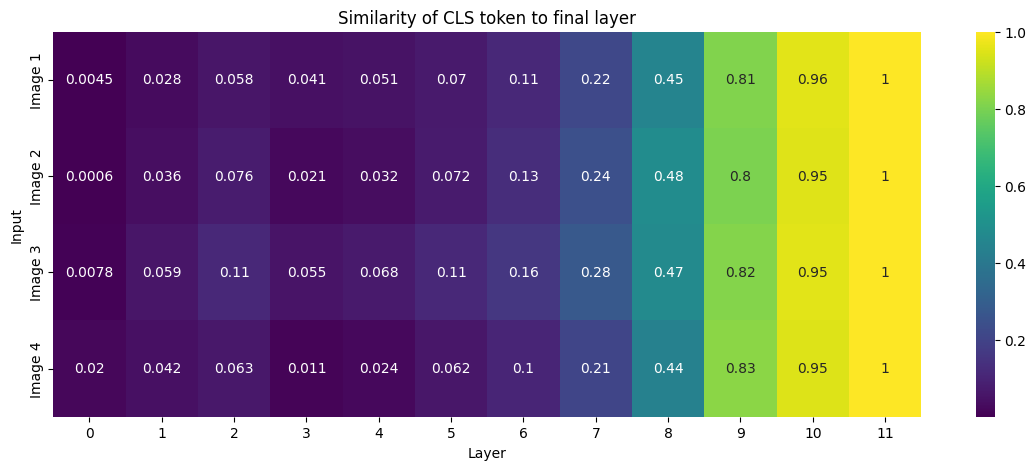

In [3]:
plt.figure(figsize=(14, 5))
sns.heatmap(similarities, annot=True, cmap='viridis', xticklabels=range(len(blocks)), yticklabels=['Image 1', 'Image 2', 'Image 3', 'Image 4'])
plt.xlabel('Layer')
plt.ylabel('Input')
plt.title('Similarity of CLS token to final layer')
plt.show()


In [4]:
vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
vitb8 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')

Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main


In [5]:
def load_image(image_path):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def extract_layer_outputs(model, x):
    activations = []

    def hook_fn(module, input, output):
        activations.append(output)

    hooks = [blk.register_forward_hook(hook_fn) for blk in model.blocks]

    with torch.no_grad():
        _ = model(x)

    for hook in hooks:
        hook.remove()

    return activations

def compute_logits_from_layers(model, layer_outputs):
    cls_tokens = [output[:, 0] for output in layer_outputs]  # CLS token
    head = model.head
    logits = [head(cls) for cls in cls_tokens]
    return logits

def compute_cosine_similarities(logits):
    final_logit = logits[-1]
    similarities = [
        F.cosine_similarity(logit, final_logit).item() for logit in logits
    ]
    return similarities

def plot_similarities(*similarity_label_pairs):
    plt.figure(figsize=(10, 6))

    for sim_scores, label in similarity_label_pairs:
        plt.plot(range(1, len(sim_scores)+1), sim_scores, marker='o', label=label)

    plt.xlabel("Transformer Layer")
    plt.ylabel("Cosine Similarity to Final Logits")
    plt.title("Logit Lens on DINO and XCiT Models")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_dino_main
Using cache found in C:\Users\olenk/.cache\torch\hub\facebookresearch_xcit_main
c:\Users\olenk\PWProjects\WB_2_Project\VisualLogitLens\dino_env\Lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
c:\Users\olenk\PWProjects\WB_2_Project\VisualLogitLens\dino_env\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Using cache found in C:\Users\olenk/.cache\torch\hub

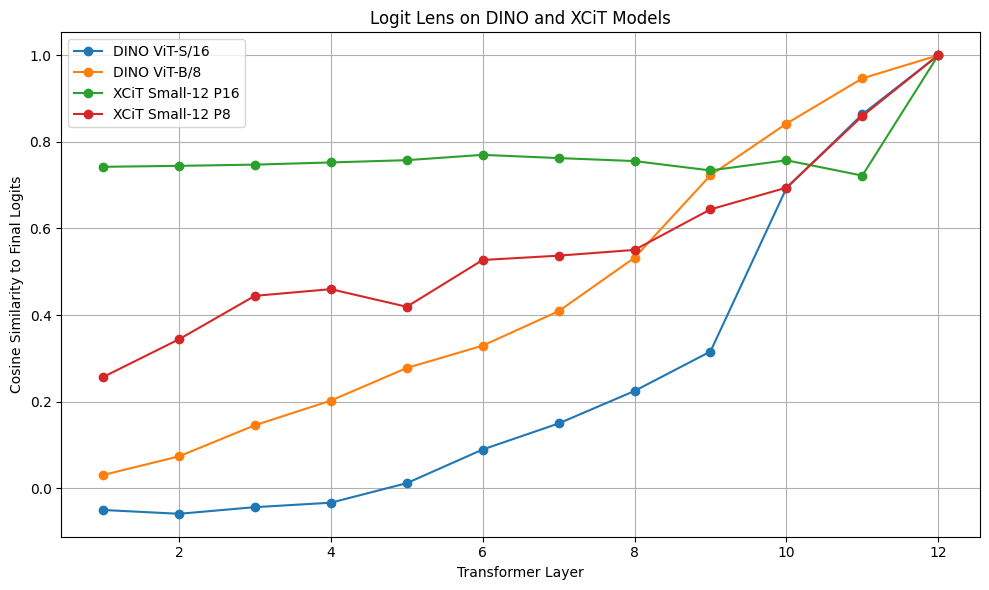

In [6]:
img_tensor = load_image('../photos/image_flower.jpg')

# Load models
vits16 = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
vitb8 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')
xcit_small_12_p16 = torch.hub.load('facebookresearch/dino:main', 'dino_xcit_small_12_p16')
xcit_small_12_p8 = torch.hub.load('facebookresearch/dino:main', 'dino_xcit_small_12_p8')


vits16.eval()
vitb8.eval()
xcit_small_12_p16.eval()
xcit_small_12_p8.eval()

# Extract and compare logits
outputs_s16 = extract_layer_outputs(vits16, img_tensor)
logits_s16 = compute_logits_from_layers(vits16, outputs_s16)
sims_s16 = compute_cosine_similarities(logits_s16)

outputs_b8 = extract_layer_outputs(vitb8, img_tensor)
logits_b8 = compute_logits_from_layers(vitb8, outputs_b8)
sims_b8 = compute_cosine_similarities(logits_b8)

outputs_12_p16 = extract_layer_outputs(xcit_small_12_p16, img_tensor)
logits_12_p16 = compute_logits_from_layers(xcit_small_12_p16, outputs_12_p16)
sims_12_p16 = compute_cosine_similarities(logits_12_p16)

outputs_12_p8 = extract_layer_outputs(xcit_small_12_p8, img_tensor)
logits_12_p8 = compute_logits_from_layers(xcit_small_12_p8, outputs_12_p8)
sims_12_p8 = compute_cosine_similarities(logits_12_p8)



plot_similarities(
    (sims_s16, "DINO ViT-S/16"),
    (sims_b8, "DINO ViT-B/8"),
    (sims_12_p16, "XCiT Small-12 P16"),
    (sims_12_p8, "XCiT Small-12 P8"),
)
